In [8]:
# !pip install pynvml
# !python -m spacy download en_core_web_lg

In [2]:
import random
import pandas as pd
import numpy as np
from csv import DictWriter
from collections import Counter

import string
import os
from datetime import datetime
from collections import defaultdict
import re

import nltk
import spacy
from spacy.matcher import Matcher
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Step 1: Refining word chunks through Part-of-Speech (POS) Tagging

The application of Part-of-Speech (POS) tagging is critical in refining word chunks, as it allows for the identification of words that significantly contribute to the meaning of the text. 

Specifically, POS tagging can help in recognizing cases where 'bear' is used as a verb instead of a noun, thereby improving the accuracy of filtering. Additionally, observing the frequency of nouns and verbs in the text enables the identification of relevant **keywords** that can be used in further filtering and analysis.

In [3]:
def clear_text(df):
    """
    Preprocess the content of tweets by removing emojis, 
    punctuation marks, and other special characters, and 
    normalize the text. Add the preprocessed content to a list.
    """
    contents = df.content.values
    clear_text = []
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF" # chinese char
        "]+", flags = re.UNICODE)
    
    for line in contents:
        line = [c for c in line if c not in string.punctuation]
        line = ''.join(line).lower().replace("’","'").replace('\n', ' ')
        line = regrex_pattern.sub(r' ',line)
        clear_text.append(line)
    return clear_text

In [4]:
def stemmer(words):
    """
    Stem each word using the Porter stemming algorithm. 
    Return a list of tuples with the original word and 
    its stemmed version.
    """
    stemmer = PorterStemmer()
    stemmed = [[w, stemmer.stem(w)] for w in words]
    return stemmed

In [5]:
def count_words(stemmed):
    """
    Take a list of stemmed words, remove stop words, count 
    the frequency of each word. Return a DataFrame with columns 
    for the number of words, root words, and sets of words that 
    have the same root.
    """
    freq = defaultdict(list)
    for w in stemmed:
        k, v = w
        if k not in ENGLISH_STOP_WORDS:
            freq[v].append(k)
    temp = sorted([(len(v), k, set(v)) for k,v in freq.items()], key=lambda x:-x[0])
    temp_df = pd.DataFrame(temp, columns=['num', 'root_word', 'words'])
    return temp_df

In [9]:
def pos_tagging(contents):
    """
    Extract nouns and verbs, and the corresponding indexes 
    of verbs containing any form of the key word 'bear'.
    """
    nlp = spacy.load('en_core_web_lg')
    verb_matcher = Matcher(nlp.vocab)
    verb_matcher.add("verb", [[{"POS": "VERB"}]])
    noun_list, verb_list, verb_bear_index = [], [], []

    for i, content in enumerate(contents):
        doc = nlp(content)
        noun_list += [n.root.text for n in doc.noun_chunks]
        verb_matches = verb_matcher(doc)
        verb_phrase = [doc[start:end].text for _, start, end in verb_matches]
        verb_list += verb_phrase
        if any(verb in ['bear', 'bears', 'beared', 'bearing'] for verb in verb_phrase):
            verb_bear_index.append(i)
    return noun_list, verb_list, verb_bear_index

In [10]:
df = pd.read_csv('merge_unique.csv').drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316749 entries, 0 to 316748
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             316749 non-null  int64  
 1   tweet_id          316749 non-null  float64
 2   created_datetime  316749 non-null  object 
 3   content           316749 non-null  object 
 4   author_id         316749 non-null  float64
 5   place_id          308781 non-null  object 
 6   location          308672 non-null  object 
 7   longitude         316749 non-null  float64
 8   latitude          316749 non-null  float64
 9   county            316749 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 24.2+ MB


In [11]:
contents = clear_text(df)
noun_list, verb_list, verb_bear_index = pos_tagging(contents)

#### Let's take a look at the most frequent nouns and verbs.

In [12]:
noun_freq = count_words(stemmer(noun_list))
noun_freq.head(50)

,num,root_word,words
0,95509,bear,"{bearings, bears, beare, bearing, bear, bearness}"
1,13587,lake,"{lakings, lake, lakes}"
2,10097,teddi,"{teddies, teddys, teddy, teddie}"
3,9414,california,"{california, californias}"
4,6231,day,"{dayes, daying, days, day}"
5,5841,time,"{timing, timee, time, times}"
6,4356,peopl,"{people, peoples}"
7,4297,amp,{amp}
8,4183,citi,"{cities, city, citys}"
9,3630,diner,"{diner, diners}"


In [13]:
verb_freq = count_words(stemmer(verb_list))
verb_freq.head(50)

,num,root_word,words
0,65124,bear,"{beared, bearring, bears, bearing, bear}"
1,17763,m,{m}
2,9970,love,"{loving, lovee, lovelies, loved, loves, love}"
3,8610,want,"{wanting, wanted, wants, want}"
4,7645,got,"{gots, got}"
5,6831,s,{s}
6,6820,look,"{looked, looking, looks, look}"
7,6513,know,"{know, knowing, knows}"
8,5976,make,"{makes, make, making}"
9,5702,come,"{comed, comeing, coming, comes, come}"


# Step 2: Clustering filtering with DBSCAN algorithm

We opted for the DBSCAN algorithm for clustering filtering as it can detect clusters without prior knowledge of the number of clusters and is well-suited for handling large datasets. We used `the Silhouette Score` and `the number of clusters` as the evaluation metric to determine the optimal hyperparameters for the algorithm. 

To enhance the efficiency of the training and analysis process, I partitioned the dataset into smaller chunks consisting of `10,000` tweets each, which were then fed into the clustering model iteratively until all tweets were processed. To measure the similarity between high-dimensional text vectors, I employed `Cosine Similarity` as the similarity metric.

The application of DBSCAN algorithm enables the identification of clusters that exhibit similarity among their content. By collecting and utilizing **keywords** that can help to identify patterns of tweets that are not related to real bears from the identified clusters, we can effectively filter out irrelevant tweets and significantly reduce noise in our dataset.

In [14]:
def vectorize(df):
    """
    Load a pre-trained language model from spaCy to 
    calculate tweets' vector representations. Return 
    two lists - one containing the tweets and the 
    other containing their corresponding vectors.
    """
    nlp = spacy.load('en_core_web_lg')
    tweet_vecs = {}
    for tweet in df.content:
        doc = nlp(tweet)
        tweet_vecs.update({tweet: doc.vector})
    tweets, vectors = list(tweet_vecs.keys()), list(tweet_vecs.values())
    return tweets, vectors

In [28]:
def split_data(i, target_df):
    mini_df = target_df.iloc[i*10_000: (i+1)*10_000]
    tweets, vectors = vectorize(mini_df)
    vectors = np.array(vectors)
    return tweets, vectors

In [21]:
def dbscan_tuning(x):
    """
    Perform a hyperparameter tuning of the DBSCAN 
    Clustering by testing a range of epsilon values. 
    Record and return the epsilon value with the 
    corresponding Silhouette Score and number of clusters.
    """
    silhouette_scores = defaultdict(list)
    for i in np.arange(0.05, 1, 0.05):
        dbscan = DBSCAN(algorithm='auto', eps=i, min_samples=30, metric='cosine').fit(x)
        if len(set(dbscan.labels_)) > 1:
            silhouette_scores[i] = [silhouette_score(x, dbscan.labels_, metric='cosine'), len(set(dbscan.labels_))]

    return silhouette_scores

In [38]:
def read_cluster(dbscan, tweets, cluster_label):
    """
    Take the output of a DBSCAN clustering model and 
    a list of tweets, selects the rows that match a 
    specified label value. Return a list of text 
    and a dictionary of word frequencies.
    """
    results = pd.DataFrame({'label':dbscan.labels_, 'tweet':tweets})
    cluster_contents = results[results.label==cluster_label].tweet.tolist()
    cluster_word_count = count_words(stemmer(' '.join(cluster_contents).split(' ')))
    return cluster_contents, cluster_word_count

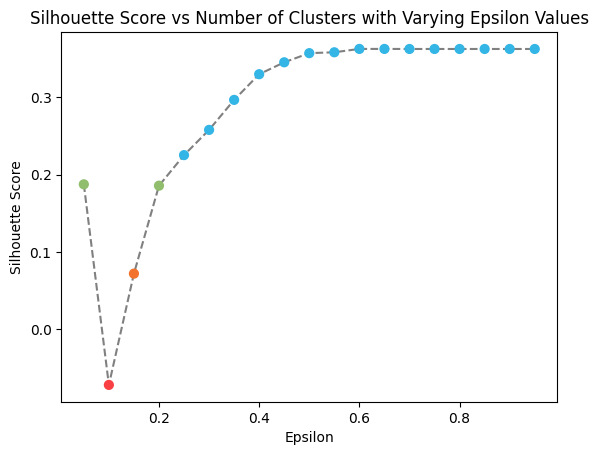

In [45]:
target_df = df.copy()
tweets, vectors = split_data(3, target_df)
silhouette_scores = dbscan_tuning(vectors)

eps = list(silhouette_scores.keys())
scores = [k for k, v in silhouette_scores.values()]
clusters = [v for k, v in silhouette_scores.values()]

colors = []
for cl in clusters:
    if cl <= 2: colors.append('#33B5E5') # blue
    elif cl <= 4: colors.append('#90BE6D') # green
    elif cl <= 6: colors.append('#F3722C') # orange
    else: colors.append('#F94144') # red
plt.plot(eps, scores, color='grey', linestyle='--')
plt.scatter(eps, scores, color=colors, zorder=10, s=40)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters with Varying Epsilon Values')
plt.show()

#### After analyzing the plot of the Silhouette Score and the number of clusters, it was observed that Silhouette Scores can reach up to 0.36 for epsilon values greater than 0.5, but the number of clusters decreases and remains at 2. This could be because DBSCAN is unable to capture all the meaningful patterns in the data with that epsilon value. Therefore, in order to strike a balance between these two metrics, I have decided to select the third epsilon value of 0.15 as the optimal choice for this data slice.

In [32]:
best_eps = eps[2]
print(f"The best epsilon value chosen by Silhouette Score is: {best_eps:.2f}")

dbscan_clusters = DBSCAN(eps=best_eps, min_samples=30, metric='cosine').fit(data)
Counter(dbscan_clusters.labels_).most_common(20)

The best epsilon value chosen by Silhouette Score is: 0.15


[(0, 5801), (-1, 3916), (1, 143), (3, 41), (2, 41), (4, 35)]

#### Now, after identifying each cluster, we can observe some clear patterns that allow us to extract keywords for identifying unrelated tweets. If we consider the cluster_label 1 here:

In [39]:
cluster_contents, cluster_word_count = read_cluster(dbscan_clusters, tweets, 1)
cluster_contents[:20]

["I'm at Starbucks (14848 Bear Valley Rd, Cottonwood, Victorville) http://t.co/v2AN24q",
 "I'm at Los Alazanes (12153 Mariposa Road, at Bear Valley Rd., Victorville) http://t.co/2Zc8FIf3",
 "I'm at The Bear Cave (San Jose, California) http://t.co/qTZYT8MJ",
 "I'm at Salinas Black Bear Diner (new location) in Salinas, CA w/ @raherrier https://t.co/Knp72hYF8F",
 "I'm at Zagg (14400 Bear Valley Rd, Victorville) http://t.co/QvXqPkHx",
 "I'm at Anime Ages In Victor Valley Mall (14400 Bear Valley Rd, Victorville) http://t.co/NG4HEtOF",
 "I'm at Walgreens (42107 Big Bear Blvd, Big Bear Lake). http://4sq.com/ciyEzd",
 "I'm at Salinas Black Bear Diner (new location) in Salinas, CA w/ @raherrier https://t.co/8Ws7BD3GuC",
 "I'm at The Mall of Victor Valley (14400 Bear Valley Rd, at Amargosa Rd, Victorville) http://t.co/CMnZURSQ",
 "I'm at Spirit Halloween (14400 Bear Valley Rd, Amargosa Rd, Victorville) http://t.co/L4PBTnz4",
 "I'm at Hungry Bear Restaurant (1313 S Harbor Blvd, Critter Country @ 

# Step 3: Keyword-based filtering of irrelevant tweets

After refining the word chunks through POS tagging and DBSCAN clustering, we gained insight into the most frequent nouns, verbs, and keywords associated with each cluster. With this knowledge, we can confidently drop tweets that use "bear" as a verb and exclude tweets that contain irrelevant keywords, effectively reducing noise in the dataset.

In [40]:
# marketing mode: bear market, bear forecasts, in the bear, during the bear, stock, tesla, uber,
# bull market, bull-bear, bear and bull, during the bull, in the bull, bulllish, bearish, bull run
# crypto: Bear Stearns
# sport terms: go bears, Chicago Bears, qb(Quarterback), linemen, 49ers, NFT, the league
# communities: okaybear
# games: build-a-bear, Ragnarök(PLATINUM)
# places: Big Bear Lake, Bear Creek, Black Bear Diner
# music: Bear In Heaven, Podington Bear(artist), Susan Bear(artist)
# food: Baked Bear, gummy bear
# cartoon: teddy bear, cocaine bear, Garbage Pail, Smokey Bear(symbol for forest fire prevention)
# hot tags: BoycottWB, TooMuchtoBearMyLove, #nft
# idioms: poke the bear, bear arms, bear a son, bear hug

In [41]:
filter_words = ['bear forecasts','bear market','bearmarket','bear mkt','bull market',
               'bull-bear','bull vs bear','bear and bull','in the bull','during the bull',
               'in the bear','during the bear','bullish','bearish','bull run','usd','$',
               'bear stearn','crypto','game','fan','playoff','eagle','team','the league',
               'teddies','teddy','pink bear','cocaine bear','cartoon bears','smokey bear',
               'build a bear','build-a-bear','okaybear','bear in heaven','platinum','bigbear',
               'bear arms','bear a son','boycottwb','toomuchtobearmylove','baked bear','stock',
               'tesla','tsla','uber','#nft','plaguenft','garbage pail','chicago bears',
               'chicagobears','go bears','qb ','qbs ','linemen','49ers','nfc','_bear','bear_',
               'podington bear','susan bear','poke the bear','poking the bear','bear hug',
               'big bear lake','bigbear','black bear diner','gummy bear','bear creek']

In [46]:
def drop_records(df,filter_words):
    drop_index = set(verb_bear_index) # drop tweets where 'bear' is used as verb
    for i in range(len(df)):
        line = df.iloc[i]['content'].lower()
        if 'bear' not in line:
            drop_index.add(i)
        for w in filter_words:
            if w in line:
                drop_index.add(i)
    print(f"We dropped {len(drop_index)} unrelated tweets.")
    return df.drop(drop_index, axis=0)

In [47]:
target_df = drop_records(target_df, filter_words)
target_ratio = len(target_df)/len(df)
print(f"After word filtering, we were left with {len(target_df)} tweets.")
print(f"The remaining ratio is {target_ratio*100:.1f}%.")

We dropped 149987 unrelated tweets.
After word filtering, we were left with 166762 tweets.
The remaining ratio is 52.6%.


#### After applying the filtering technique, we were able to retain 52.6% of the original dataset, which translates to 166,762 tweets. With this filtered data, we can now dive into it to ensure its quality.

In [48]:
contents_t = clear_text(target_df)
noun_list_t, verb_list_t, verb_bear_index_t = pos_tagging(contents_t)

In [49]:
noun_freq_t = count_words(stemmer(noun_list_t))
noun_freq_t.head(50)

,num,root_word,words
0,81426,bear,"{bearings, bears, bearing, bear, bearness}"
1,3524,citi,"{cities, city, citys}"
2,3411,day,"{daying, days, day}"
3,3337,california,"{california, californias}"
4,2991,time,"{timing, time, times}"
5,2364,mountain,"{mountains, mountaineers, mountaineer, mountain}"
6,2094,amp,{amp}
7,2045,snow,"{snows, snow, snowing}"
8,1968,friend,"{friends, friend}"
9,1786,cabin,"{cabins, cabin}"


In [50]:
verb_freq_t = count_words(stemmer(verb_list_t))
verb_freq_t.head(50)

,num,root_word,words
0,10633,m,{m}
1,4953,love,"{loving, lovee, loved, loves, love}"
2,4317,want,"{wanting, wants, wanted, want}"
3,4184,got,"{gots, got}"
4,3852,look,"{look, looked, looking, looks}"
5,3751,s,{s}
6,3180,go,"{gos, going}"
7,3148,come,"{comed, comeing, coming, comes, come}"
8,3063,know,"{know, knowing, knows}"
9,2863,make,"{makes, make, making}"


In [51]:
target_df.to_csv('filtered.csv')